In [1]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可:
# Also add the following code, so that every time the environment (kernel) starts, just run the following code:
import sys
sys.path.append('/home/aistudio/external-libraries')

### 导入库

In [2]:
#导入需要的包
import numpy as np
import paddle as paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import os

2023-01-08 15:03:48,163-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2023-01-08 15:03:48,633-INFO: generated new fontManager


In [3]:
TRAIN_BUF_SIZE=51200
TRAIN_BATCH_SIZE=51200
TEST_BUF_SIZE=12800
TEST_BATCH_SIZE=12800
#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.train(),
                          buf_size=TRAIN_BUF_SIZE),
    batch_size=TRAIN_BATCH_SIZE)
#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.test(),
                          buf_size=TEST_BUF_SIZE),
    batch_size=TEST_BATCH_SIZE)

train_iterator = next(train_reader())
test_iterator = next(test_reader())

# 将数据转为numpy Array
train_data = np.array([data[0] for data in train_iterator]).astype("float32")
test_data = np.array([data[0] for data in test_iterator]).astype("float32")

train_label = np.array([data[1] for data in train_iterator]).astype("float32")
test_label = np.array([data[1] for data in test_iterator]).astype("float32")

# print(train_data.shape)
# 将白底黑字转化为黑底白字拼接在原矩阵下
train_data = np.vstack((train_data, -train_data))
test_data = np.vstack((test_data, -test_data))

# 构造新label训练集和测试集
train_label = np.vstack((train_label.reshape(-1, 1), train_label.reshape(-1, 1)))
test_label = np.vstack((test_label.reshape(-1, 1), test_label.reshape(-1, 1)))

# print(train_data.shape)


train_index = [i for i in range(len(train_data))]
# print(train_index)
np.random.shuffle(train_index)  # 打乱索引
train_data = train_data[train_index]
train_label = train_label[train_index]

test_index = [i for i in range(len(test_data))]
np.random.shuffle(test_index)  # 打乱索引
test_data = test_data[test_index]
test_label = test_label[test_index]




# print(train_data.shape)
# print(type(train_data))
#用于打印，查看mnist数据
# train_data=paddle.dataset.mnist.train();
# sampledata=next(train_data())
 


Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


定义reader生成函数

In [4]:
def readerGenerator(data, label):
    def reader():
        for i in  range(len(data)):
            yield data[i], int(label[i])
    return reader

创建train_reader和test_reader

In [5]:
train_reader = paddle.batch(paddle.reader.shuffle(
    reader=readerGenerator(train_data, train_label),buf_size=512),
                    batch_size=128)

test_reader = paddle.batch(paddle.reader.shuffle(
    reader=readerGenerator(test_data, test_label),buf_size=512),
                          batch_size=128)

In [6]:
# 定义多层感知器 
def multilayer_perceptron(input): 
    # 第一个全连接层，激活函数为ReLU 
    hidden1 = fluid.layers.fc(input=input, size=200, act='relu') 
    # 第二个全连接层，激活函数为ReLU 
    hidden2 = fluid.layers.fc(input=hidden1, size=200, act='relu') 
    # 以softmax为激活函数的全连接输出层，输出层的大小必须为数字的个数10 
    prediction = fluid.layers.fc(input=hidden2, size=10, act='softmax') 
    return prediction 

In [7]:
def multilayer_perceptron(input):
    conv_pool_1 = fluid.nets.simple_img_conv_pool(
        input=input,
        filter_size=5,
        num_filters=20,
        pool_size=2,
        pool_stride=2,
        act="relu")
    conv_pool_1 = fluid.layers.batch_norm(conv_pool_1)
    # 第二个卷积-池化层
    # 使用50个5*5的滤波器，池化大小为2，池化步长为2，激活函数为Relu
    conv_pool_2 = fluid.nets.simple_img_conv_pool(
        input=conv_pool_1,
        filter_size=5,
        num_filters=50,
        pool_size=2,
        pool_stride=2,
        act="relu")
    # 以softmax为激活函数的全连接输出层，输出层的大小必须为数字的个数10
    prediction = fluid.layers.fc(input=conv_pool_2, size=10, act='softmax')
    return prediction

In [8]:
# 输入的原始图像数据，大小为1*28*28
image = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')#单通道，28*28像素值
# 标签，名称为label,对应输入图片的类别标签
label = fluid.layers.data(name='label', shape=[1], dtype='int64')          #图片标签

In [9]:
# 获取分类器
predict = multilayer_perceptron(image)

In [10]:
#使用交叉熵损失函数,描述真实样本标签和预测概率之间的差值
cost = fluid.layers.cross_entropy(input=predict, label=label)  
# 使用类交叉熵函数计算predict和label之间的损失函数
avg_cost = fluid.layers.mean(cost)
# 计算分类准确率
acc = fluid.layers.accuracy(input=predict, label=label)

In [11]:
 #使用Adam算法进行优化, learning_rate 是学习率(它的大小与网络的训练收敛速度有关系)
# optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.0001)
# optimizer = paddle.fluid.optimizer.Adadelta(0.0001) # 使用Adadelta优化器
# optimizer = paddle.fluid.optimizer.Momentum(0.0001, 0.9) # 使用Momentum优化器
optimizer = fluid.optimizer.RMSProp(0.0001) #使用RMSProp优化器


opts = optimizer.minimize(avg_cost)

In [12]:
# 定义使用CPU还是GPU，使用CPU时use_cuda = False,使用GPU时use_cuda = True
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
# 获取测试程序
test_program = fluid.default_main_program().clone(for_test=True)
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

W0108 15:03:54.861925    98 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 11.2, Runtime API Version: 9.0
W0108 15:03:54.866596    98 device_context.cc:260] device: 0, cuDNN Version: 7.6.


[]

（2）告知网络传入的数据分为两部分，第一部分是image值，第二部分是label值

DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。

In [13]:

feeder = fluid.DataFeeder(place=place, feed_list=[image, label])

(3)展示模型训练曲线

In [14]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

Pass:0, Batch:0, Cost:3.99843, Accuracy:0.09375
Pass:0, Batch:200, Cost:0.79150, Accuracy:0.76562
Pass:0, Batch:400, Cost:0.27912, Accuracy:0.92188
Pass:0, Batch:600, Cost:0.26049, Accuracy:0.92969
Test:0, Cost:0.17168, Accuracy:0.94755
Pass:1, Batch:0, Cost:0.19578, Accuracy:0.96875
Pass:1, Batch:200, Cost:0.14359, Accuracy:0.96094
Pass:1, Batch:400, Cost:0.09261, Accuracy:0.97656
Pass:1, Batch:600, Cost:0.09963, Accuracy:0.97656
Test:1, Cost:0.10320, Accuracy:0.96771
Pass:2, Batch:0, Cost:0.16212, Accuracy:0.96094
Pass:2, Batch:200, Cost:0.14418, Accuracy:0.97656
Pass:2, Batch:400, Cost:0.05961, Accuracy:0.97656
Pass:2, Batch:600, Cost:0.07147, Accuracy:0.96875
Test:2, Cost:0.08182, Accuracy:0.97417
Pass:3, Batch:0, Cost:0.07147, Accuracy:0.99219
Pass:3, Batch:200, Cost:0.12689, Accuracy:0.97656
Pass:3, Batch:400, Cost:0.04627, Accuracy:0.99219
Pass:3, Batch:600, Cost:0.07892, Accuracy:0.96094
Test:3, Cost:0.07062, Accuracy:0.97791
Pass:4, Batch:0, Cost:0.03638, Accuracy:0.98438
Pass

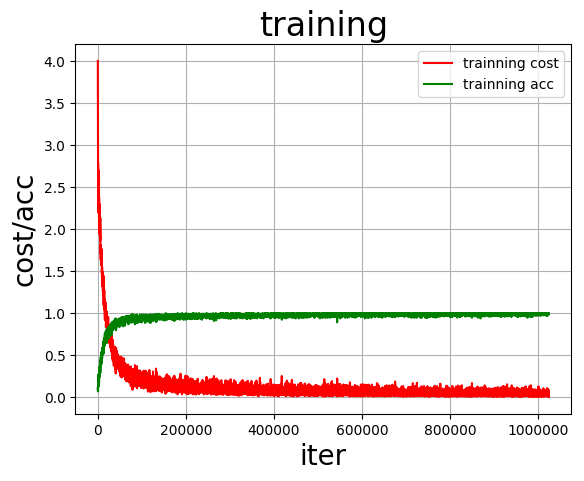

In [15]:
EPOCH_NUM=10
BATCH_SIZE=128
model_save_dir = "/home/aistudio/work/hand.inference.model"
for pass_id in range(EPOCH_NUM):
    # 进行训练
    for batch_id, data in enumerate(train_reader()):                         #遍历train_reader
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),#运行主程序
                                        feed=feeder.feed(data),              #给模型喂入数据
                                        fetch_list=[avg_cost, acc])          #fetch 误差、准确率  
        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
        
        # 每200个batch打印一次信息  误差、准确率
        if batch_id % 200 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' %
                  (pass_id, batch_id, train_cost[0], train_acc[0]))

    # 进行测试
    test_accs = []
    test_costs = []
    #每训练一轮 进行一次测试
    for batch_id, data in enumerate(test_reader()):                         #遍历test_reader
        test_cost, test_acc = exe.run(program=test_program, #执行训练程序
                                      feed=feeder.feed(data),               #喂入数据
                                      fetch_list=[avg_cost, acc])           #fetch 误差、准确率
        test_accs.append(test_acc[0])                                       #每个batch的准确率
        test_costs.append(test_cost[0])                                     #每个batch的误差
        
       
    # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                         #每轮的平均误差
    test_acc = (sum(test_accs) / len(test_accs))                            #每轮的平均准确率
    print('Test:%d, Cost:%0.5f, Accuracy:%0.5f' % (pass_id, test_cost, test_acc))
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['image'],    #推理（inference）需要 feed 的数据
                                  [predict],    #保存推理（inference）结果的 Variables
                                  exe)             #executor 保存 inference model

print('训练模型保存完成！')
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

（1）图片预处理

在预测之前，要对图像进行预处理。

首先进行灰度化，然后压缩图像大小为28*28，接着将图像转换成一维向量，最后再对一维向量进行归一化处理。

In [16]:
def load_image(file):
    im = Image.open(file).convert('L')                        #将RGB转化为灰度图像，L代表灰度图像，像素值在0~255之间
    im = im.resize((28, 28), Image.ANTIALIAS)                 #resize image with high-quality 图像大小为28*28
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)#返回新形状的数组,把它变成一个 numpy 数组以匹配数据馈送格式。
    # print(im)
    im = im / 255.0 * 2.0 - 1.0                               #归一化到【-1~1】之间
    return im


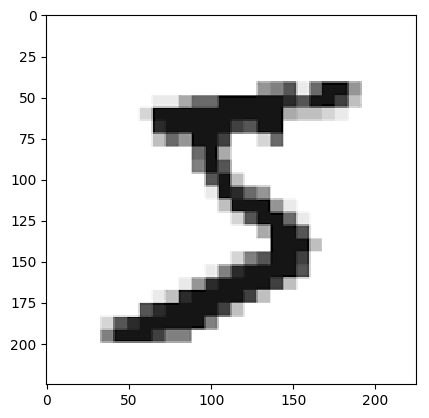

In [17]:
infer_path='/home/aistudio/work/5.png'
img = Image.open(infer_path)
plt.imshow(img)   #根据数组绘制图像
plt.show()        #显示图像

创建Executer

In [18]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

(4)开始预测

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

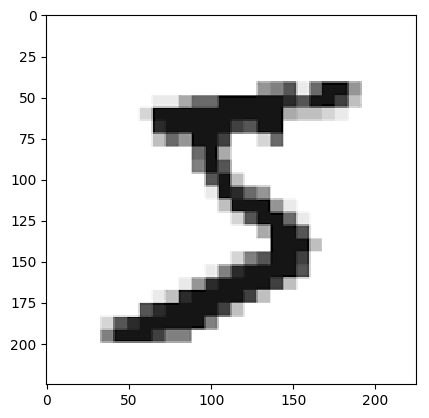

该图片的预测结果的label为: 5


In [19]:
# 加载数据并开始预测
plt.imshow(img)   #根据数组绘制图像
plt.show()        #显示图像
with fluid.scope_guard(inference_scope):
    #获取训练好的模型
    #从指定目录中加载 推理model(inference model)
    [inference_program,                                            #推理Program
     feed_target_names,                                            #是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称。 
     fetch_targets] = fluid.io.load_inference_model(model_save_dir,#fetch_targets：是一个 Variable 列表，从中我们可以得到推断结果。model_save_dir：模型保存的路径
                                                    infer_exe)     #infer_exe: 运行 inference model的 executor
    
    img = load_image(infer_path)

    results = infer_exe.run(program=inference_program,               #运行推测程序
                   feed={feed_target_names[0]: img},           #喂入要预测的img
                   fetch_list=fetch_targets)                   #得到推测结果,  
    # 获取概率最大的label
    lab = np.argsort(results)                                  #argsort函数返回的是result数组值从小到大的索引值
    
    print("该图片的预测结果的label为: %d" % lab[0][0][-1])     #-1代表读取数组中倒数第一列  

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 